In [1]:
!curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py > /dev/null
!python pytorch-xla-env-setup.py --version 20200515 --apt-packages libomp5 libopenblas-dev > /dev/null
!pip install transformers==2.5.1 > /dev/null
!pip install pandarallel > /dev/null
!pip install catalyst==20.4.2 > /dev/null
!pip install kaggle
!pip install emoji

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4264  100  4264    0     0  53300      0 --:--:-- --:--:-- --:--:-- 53300
Copying gs://tpu-pytorch/wheels/torch-nightly+20200515-cp36-cp36m-linux_x86_64.whl...
- [1 files][ 91.0 MiB/ 91.0 MiB]                                                
Operation completed over 1 objects/91.0 MiB.                                     
Copying gs://tpu-pytorch/wheels/torch_xla-nightly+20200515-cp36-cp36m-linux_x86_64.whl...
- [1 files][119.5 MiB/119.5 MiB]                                                
Operation completed over 1 objects/119.5 MiB.                                    
Copying gs://tpu-pytorch/wheels/torchvision-nightly+20200515-cp36-cp36m-linux_x86_64.whl...
/ [1 files][  2.3 MiB/  2.3 MiB]                                                
Operation completed over 1 objects/2.3 MiB.                                      
ERROR:

In [0]:
# arr=[]
# while(1):
#  arr.append(1)

In [3]:
%load_ext autoreload
%autoreload 2 

from google.colab import drive

drive.mount("/content/drive", force_remount=True)

import sys
sys.path.append('drive/My Drive/toxic_comment/scripts')

import os
os.environ['XLA_USE_BF16'] = "1"

import gc
import time
import json
import random
from pathlib import Path
from importlib import reload

import utility as utils
import albumentations as alb
import data_cleaning as clean
import models
import config

reload(utils)
reload(alb)
reload(clean)
reload(models)
reload(config)


import numpy as np
import pandas as pd
from transformers import AutoModel, AutoTokenizer
from tqdm import tqdm
tqdm.pandas()

from pandarallel import pandarallel

import torch
from torch.utils.data import DataLoader
import torch_xla.core.xla_model as xm
import torch_xla.distributed.xla_multiprocessing as xmp
from catalyst.data.sampler import DistributedSamplerWrapper, BalanceClassSampler

pandarallel.initialize(nb_workers=4, progress_bar=False)

Mounted at /content/drive
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [4]:
root_dir = "drive/My Drive/toxic_comment"

# *Git related variables

GIT_REPOSITORY = "toxic-comment" 
GIT_CREDENTIALS = Path(root_dir, "credentials/git_creds.json")

def git_path():
  with open(GIT_CREDENTIALS) as cred_json:
    creds = json.load(cred_json)

  GIT_PATH = "https://" + creds['token'] + "@github.com/" + creds['username'] + "/" + GIT_REPOSITORY + ".git"
  print(f'GIT_PATH: {GIT_PATH}')

  return GIT_PATH, creds['email'], creds['username']

GIT_PATH, GIT_EMAIL, GIT_USERNAME = git_path()


# *Model related variables
SEED = 42
MODEL = 'xlm-roberta-large'
MODEL_VERSION = 'v1'
MAX_LENGTH = 224

LANGS = {
    'en': 'english',
    'it': 'italian', 
    'fr': 'french', 
    'es': 'spanish',
    'tr': 'turkish', 
    'ru': 'russian',
    'pt': 'portuguese'
}

# *Data access
data_dir = Path(root_dir, "data")
data_t_dir = data_dir/"jigsaw-toxic/translations"

# *Model paths
model_base_dir = Path(root_dir, "models")
model_dir = (model_base_dir/MODEL/MODEL_VERSION)

# *Files
train_file1 = "jigsaw-toxic/jigsaw-toxic-comment-train.csv"
train_file2 = "jigsaw-toxic/jigsaw-unintended-bias-train.csv"
val_file = "jigsaw-toxic/validation.csv"
test_file = "jigsaw-toxic/test.csv"
sub_file = "jigsaw-toxic/sample_submission.csv"
open_subtitles_file = 'open-subtitles-toxic/open-subtitles-synthesic.csv'

out_dir = Path(root_dir, 'output')

GIT_PATH: https://5ee99ff256ca8a15f73f1b37d96c87ebed5facc6@github.com/quancore/toxic-comment.git


In [5]:
!git clone "{GIT_PATH}" ./temp      # clone github repository to temp folder
!mv ./temp/.git "{root_dir}/.git"       # move all files/folders in temp folder to folder defined in project path
!rm -rf ./temp                      # remove all the files/folders in temp folder

Cloning into './temp'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 6 (delta 0), reused 3 (delta 0), pack-reused 0
Unpacking objects: 100% (6/6), done.


In [0]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

In [6]:
%%time
# Read the data and external sources
dir_dict = {'base_dir': data_dir, 'base_t_dir': data_t_dir, 'train_file1': train_file1, 
            'train_file2': train_file2, 'val_file': val_file, 'test_file': test_file, 'sub_file': sub_file}
train, valid, test, sub = utils.read_data(dir_dict, list(LANGS.keys()))
external = utils.read_external_data((data_dir/'external'), list(LANGS.values()))

Translation has not found: drive/My Drive/toxic_comment/data/jigsaw-toxic/translations/jigsaw-toxic-comment-train-google-en-cleaned.csv
File not found: drive/My Drive/toxic_comment/data/external/english-external-cleaned.csv
File not found: drive/My Drive/toxic_comment/data/external/italian-external-cleaned.csv
File not found: drive/My Drive/toxic_comment/data/external/french-external-cleaned.csv
File not found: drive/My Drive/toxic_comment/data/external/spanish-external-cleaned.csv
File not found: drive/My Drive/toxic_comment/data/external/russian-external-cleaned.csv
File not found: drive/My Drive/toxic_comment/data/external/portuguese-external-cleaned.csv
CPU times: user 45.3 s, sys: 4.43 s, total: 49.8 s
Wall time: 1min 4s


In [7]:
train

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,severe_toxicity,identity_attack,asian,atheist,bisexual,black,buddhist,christian,female,heterosexual,hindu,homosexual_gay_or_lesbian,intellectual_or_learning_disability,jewish,latino,male,muslim,other_disability,other_gender,other_race_or_ethnicity,other_religion,other_sexual_orientation,physical_disability,psychiatric_or_mental_illness,transgender,white,created_date,publication_id,parent_id,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count,lang,Unnamed: 0,Unnamed: 0.1
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,en,NaN,NaN
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,en,NaN,NaN
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,en,NaN,NaN
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,en,NaN,NaN
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,en,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223389,ffeb7faf9662ed0f,"(UTC)\n\n :: FYI, atualmente estou em conflito...",0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,pt,223544.0,223544.0
223390,ffe3a3e2d8f0eb9b,Esta é a minha sandbox da página de discussão ...,0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,pt,223545.0,223545.0
223391,ffebe90c8d5acaba,"""\n\n == IRAN ==\n Isso mesmo, Irã. Foi o noss...",1,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,pt,223546.0,223546.0
223392,fff23c3e174e895e,"""\n li esta página de discussão e fiquei impre...",0,0.0,1.0,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,pt,223547.0,223547.0


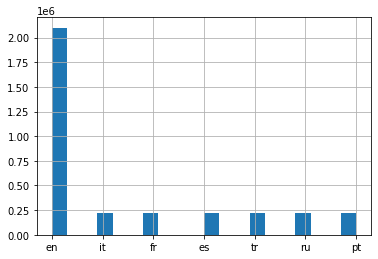

In [8]:
train['lang'].hist(bins=20);

In [9]:
train['comment_text'].isna().sum()

0

In [10]:
valid

,comment_text,lang,toxic
id,,,
0,Este usuario ni siquiera llega al rango de ...,es,0
1,Il testo di questa voce pare esser scopiazzato...,it,0
2,Vale. Sólo expongo mi pasado. Todo tiempo pasa...,es,1
3,Bu maddenin alt başlığı olarak uluslararası i...,tr,0
4,Belçika nın şehirlerinin yanında ilçe ve belde...,tr,0
...,...,...,...
7995,Il fatto è che la pagina dei personaggi minor...,it,0
7996,El imbesil ete dela luna no se entera ni ostia...,es,1
7997,olum sız manyakmısınz siz adam sıze sanal yıld...,tr,1


In [11]:
external.head(50)

,id,text,toxic,lang
0,20948,en güzel uyuyan insan ödülü jeon jungkooka gid...,0,tr
1,10134,mekanı cennet olsun saygılar sayın avukatımız...,0,tr
2,23457,kızlar aranızda kas yığını beylere düşenler ol...,0,tr
3,18401,biraz ders çalışayım tembellik ve uyku düşman...,0,tr
4,17525,trezeguet yerine el sharawy daha iyi olmaz mı,0,tr
5,11996,bence de olması gerekiyor hatta meslek lisesi...,0,tr
6,38452,mutlu görünümlü ama daima mutsuz olanlar burad...,0,tr
7,12615,liraya traş oldum arkadaşım diyor ki ne kesiyo...,0,tr
8,13520,reis bu ülkenin devlet başkanı ve ak parti gen...,1,tr
9,45562,var olan ancak düşünüldüğü kadarıyla vardır ...,0,tr


In [0]:
tokenizer = AutoTokenizer.from_pretrained(MODEL)

In [0]:
input_cols_external = ['text']

external_dataset = models.DatasetRetriever(
    tokenizer,
    labels_or_ids=external['toxic'].values, 
    comment_texts=external[input_cols_external].values, 
    langs=external['lang'].values,
    maxlen=MAX_LENGTH,
)

del external
gc.collect();

In [0]:
input_cols_dev = ['comment_text']

train_dataset = models.DatasetRetriever(
    tokenizer,
    labels_or_ids=train['toxic'].values, 
    comment_texts=train[input_cols_dev].values, 
    langs=train['lang'].values,
    open_subtitles_path=data_dir/open_subtitles_file,
    maxlen=MAX_LENGTH,
    use_train_transforms=True,
)

del train
gc.collect();

In [0]:
validation_tune_dataset = models.DatasetRetriever(
    tokenizer,
    labels_or_ids=valid['toxic'].values, 
    comment_texts=valid[input_cols_dev].values, 
    langs=valid['lang'].values,
    open_subtitles_path=data_dir/open_subtitles_file,
    maxlen=MAX_LENGTH,
    use_train_transforms=True,
)

valid = clean.clean_data(valid, input_cols_dev)

validation_dataset = models.DatasetRetriever(
    tokenizer,
    labels_or_ids=valid['toxic'].values, 
    comment_texts=valid[input_cols_dev].values, 
    langs=valid['lang'].values,
    maxlen=MAX_LENGTH,
    use_train_transforms=False,
)

del valid
gc.collect();

In [0]:
input_cols_test = ['content']
test = clean.clean_data(test, input_cols_test)

test_dataset = models.DatasetRetriever(
    tokenizer,
    labels_or_ids=test.index.values, 
    comment_texts=test[input_cols_test].values, 
    langs=test['lang'].values,
    maxlen=MAX_LENGTH,
    use_train_transforms=False,
    test=True
)

In [0]:
transformer = AutoModel.from_pretrained(MODEL)

In [0]:
net = models.ToxicSimpleNNModel(transformer)

In [19]:
net

ToxicSimpleNNModel(
  (backbone): XLMRobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(250002, 1024, padding_idx=1)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerN

In [0]:
import warnings
warnings.filterwarnings("ignore")

def _mp_fn(rank, flags):
    device = xm.xla_device()
    net.to(device)

    external_sampler = DistributedSamplerWrapper(
        sampler=BalanceClassSampler(labels=external_dataset.get_labels(), mode="downsampling"),
        num_replicas=xm.xrt_world_size(),
        rank=xm.get_ordinal(),
        shuffle=True
    )
    external_loader = torch.utils.data.DataLoader(
        external_dataset,
        batch_size=config.TrainGlobalConfig.batch_size,
        sampler=external_sampler,
        pin_memory=False,
        drop_last=True,
        num_workers=config.TrainGlobalConfig.num_workers,
    )

    train_sampler = DistributedSamplerWrapper(
        sampler=BalanceClassSampler(labels=train_dataset.get_labels(), mode="downsampling"),
        num_replicas=xm.xrt_world_size(),
        rank=xm.get_ordinal(),
        shuffle=True
    )
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=config.TrainGlobalConfig.batch_size,
        sampler=train_sampler,
        pin_memory=False,
        drop_last=True,
        num_workers=config.TrainGlobalConfig.num_workers,
    )
    validation_sampler = torch.utils.data.distributed.DistributedSampler(
        validation_dataset,
        num_replicas=xm.xrt_world_size(),
        rank=xm.get_ordinal(),
        shuffle=False
    )
    validation_loader = torch.utils.data.DataLoader(
        validation_dataset,
        batch_size=config.TrainGlobalConfig.batch_size,
        sampler=validation_sampler,
        pin_memory=False,
        drop_last=False,
        num_workers=config.TrainGlobalConfig.num_workers
    )
    validation_tune_sampler = torch.utils.data.distributed.DistributedSampler(
        validation_tune_dataset,
        num_replicas=xm.xrt_world_size(),
        rank=xm.get_ordinal(),
        shuffle=True
    )
    validation_tune_loader = torch.utils.data.DataLoader(
        validation_tune_dataset,
        batch_size=config.TrainGlobalConfig.batch_size,
        sampler=validation_tune_sampler,
        pin_memory=False,
        drop_last=False,
        num_workers=config.TrainGlobalConfig.num_workers
    )
    test_sampler = torch.utils.data.distributed.DistributedSampler(
        test_dataset,
        num_replicas=xm.xrt_world_size(),
        rank=xm.get_ordinal(),
        shuffle=False
    )
    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=config.TrainGlobalConfig.batch_size,
        sampler=test_sampler,
        pin_memory=False,
        drop_last=False,
        num_workers=config.TrainGlobalConfig.num_workers
    )
    if rank == 0:
        time.sleep(1)
    
    fitter = models.TPUFitter(model=net, device=device, config=config.TrainGlobalConfig, 
                              base_model_path=model_base_dir, model_name=MODEL, model_version=MODEL_VERSION, out_path=out_dir)
    fitter.fit(train_loader, validation_loader)
    
    for val_epoch in range(2):
      fitter.run_validation_tuning(validation_tune_loader, val_epoch)
      # xm.master_print(f'Tuning on external data: {val_epoch}')
      # fitter.run_validation_tuning(external_loader, val_epoch)
      # fitter.run_pseudolabeling(test_loader, val_epoch)

In [21]:
FLAGS={}
xmp.spawn(_mp_fn, args=(FLAGS,), nprocs=8, start_method='fork')

**** Directory structure created ****
Fitter prepared. Device is xla:1
**** Fitting process has been started ****

2020-05-31T19:04:21.086350
LR: 5e-06 
Epoch:0
**** Epoch training has started: 0 ****
Train Step 0, loss: 0.00000, final_score: 0.00000, time: 0.90838
Train Step 50, loss: 0.73398, final_score: 0.48565, time: 278.93813
Train Step 100, loss: 0.72770, final_score: 0.49984, time: 341.19105
Train Step 150, loss: 0.71089, final_score: 0.54342, time: 403.86972
Train Step 200, loss: 0.63879, final_score: 0.68616, time: 466.23505
Train Step 250, loss: 0.58587, final_score: 0.76689, time: 528.44172
Train Step 300, loss: 0.55251, final_score: 0.81204, time: 590.92672
Train Step 350, loss: 0.52695, final_score: 0.84225, time: 653.54522
Train Step 400, loss: 0.50143, final_score: 0.86747, time: 716.28493
Train Step 450, loss: 0.48757, final_score: 0.88160, time: 778.31325
Train Step 500, loss: 0.47449, final_score: 0.89300, time: 840.79354
Train Step 550, loss: 0.46345, final_score: 0

In [0]:
tokenizer.save_pretrained(model_dir)
transformer.save_pretrained(model_dir)

In [23]:
config_path = (model_dir/"config.json")
model_metadata = {'model_name': MODEL, "model_version": MODEL_VERSION, "max_len": MAX_LENGTH}

with open(config_path) as f:
    data = json.load(f)

data.update(model_metadata)

with open(config_path, 'w') as f:
    json.dump(data, f, indent=3, sort_keys=True)

{'architectures': ['XLMRobertaModel'], 'attention_probs_dropout_prob': 0.1, 'bos_token_id': 0, 'do_sample': False, 'eos_token_id': 2, 'eos_token_ids': None, 'finetuning_task': None, 'hidden_act': 'gelu', 'hidden_dropout_prob': 0.1, 'hidden_size': 1024, 'id2label': {'0': 'LABEL_0', '1': 'LABEL_1'}, 'initializer_range': 0.02, 'intermediate_size': 4096, 'is_decoder': False, 'label2id': {'LABEL_0': 0, 'LABEL_1': 1}, 'layer_norm_eps': 1e-05, 'length_penalty': 1.0, 'max_length': 20, 'max_position_embeddings': 514, 'model_type': 'xlm-roberta', 'num_attention_heads': 16, 'num_beams': 1, 'num_hidden_layers': 24, 'num_labels': 2, 'num_return_sequences': 1, 'output_attentions': False, 'output_hidden_states': False, 'output_past': True, 'pad_token_id': 1, 'pruned_heads': {}, 'repetition_penalty': 1.0, 'temperature': 1.0, 'top_k': 50, 'top_p': 1.0, 'torchscript': False, 'type_vocab_size': 1, 'use_bfloat16': False, 'vocab_size': 250002, 'model_name': 'xlm-roberta-large', 'model_version': 'v1', 'max_

In [0]:
with open(Path(root_dir, "credentials/kaggle.json")) as cred_json:
    creds = json.load(cred_json)

os.environ["KAGGLE_USERNAME"] = creds['username']
os.environ["KAGGLE_KEY"] = creds['key']

from kaggle.api.kaggle_api_extended import KaggleApi
new_model = {
  "title": f"{MODEL}", 
  "description": "Trained model for toxic comment challange",
  "id": f"quanncore/{MODEL.lower()}", 
  "licenses": [{"name": "CC0-1.0"}],
  "resources": [
    {
      "path": "last-checkpoint.bin",
      "description": "Saved model file"
    },
    {
      "path": "sentencepiece.bpe.model",
      "description": "sentencepiece model"
    },
    {
      "path": "special_tokens_map.json",
      "description": "Special token map"
    },
    {
      "path": "log.txt",
      "description": "Log file of trained model"
    },
    {
      "path": "tokenizer_config.json",
      "description": "Tokenizer config"
    },
    {
      "path": "config.json",
      "description": "Model config"
    }
  ],
}

def update_model_kaggle():
  api = KaggleApi()
  api.authenticate()

  dataset_id = f"quanncore/{MODEL.lower()}"
  with open((model_dir/'dataset-metadata.json'), 'w') as fp:
    json.dump(new_model, fp)
  
  response = api.dataset_status(dataset_id)
  if response == None:
    print('Creating a new dataset\n')
    api.dataset_create_new(model_dir)
  else:
    print(f'Got response: {response}\n. Creating a new version\n')
    api.dataset_create_version(model_dir, version_notes=f'new version: {MODEL_VERSION.lower()}')

In [25]:
update_model_kaggle()

  0%|          | 0.00/39.8k [00:00<?, ?B/s]

Got response: ready
. Creating a new version

Starting upload for file log.txt


100%|██████████| 39.8k/39.8k [00:01<00:00, 35.0kB/s]
  0%|          | 0.00/150 [00:00<?, ?B/s]

Upload successful: log.txt (40KB)
Starting upload for file special_tokens_map.json


100%|██████████| 150/150 [00:01<00:00, 139B/s]
  0%|          | 0.00/16.0 [00:00<?, ?B/s]

Upload successful: special_tokens_map.json (150B)
Starting upload for file tokenizer_config.json


100%|██████████| 16.0/16.0 [00:00<00:00, 18.9B/s]
  0%|          | 0.00/1.15k [00:00<?, ?B/s]

Upload successful: tokenizer_config.json (16B)
Starting upload for file config.json


100%|██████████| 1.15k/1.15k [00:00<00:00, 1.23kB/s]
  0%|          | 0.00/4.83M [00:00<?, ?B/s]

Upload successful: config.json (1KB)
Starting upload for file sentencepiece.bpe.model


100%|██████████| 4.83M/4.83M [00:00<00:00, 5.91MB/s]
  0%|          | 0.00/2.09G [00:00<?, ?B/s]

Upload successful: sentencepiece.bpe.model (5MB)
Starting upload for file pytorch_model.bin


100%|██████████| 2.09G/2.09G [00:37<00:00, 59.8MB/s]
  0%|          | 0.00/2.09G [00:00<?, ?B/s]

Upload successful: pytorch_model.bin (2GB)
Starting upload for file last-checkpoint.bin


100%|██████████| 2.09G/2.09G [00:32<00:00, 68.8MB/s]


Upload successful: last-checkpoint.bin (2GB)


In [16]:
%cd "{root_dir}"
!git status

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-16-1f5d9924db09>", line 1, in <module>
    get_ipython().magic('cd "{root_dir}"')
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2160, in magic
    return self.run_line_magic(magic_name, magic_arg_s)
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2081, in run_line_magic
    result = fn(*args,**kwargs)
  File "<decorator-gen-91>", line 2, in cd
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/magic.py", line 188, in <lambda>
    call = lambda f, *a, **k: f(*a, **k)
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/magics/osm.py", line 288, in cd
    oldcwd = py3compat.getcwd()
OSError: [Errno 107] Transport endpoint is not connected

During handling of the above exception, a

OSError: ignored

In [0]:
!git add .

In [14]:
# todo: please fill the lb score after making submission
git_comment = f'Model: {MODEL} Version: {MODEL_VERSION} Kaggle LB Score: {0.9301}'
!git commit -m "{git_comment}"
!git config --global user.email "{GIT_EMAIL}"
!git config --global user.name "{GIT_USERNAME}"
!git push origin master

[master 5164ccb] Model: xlm-roberta-large Version: v1 Kaggle LB Score: 0.9301
 11 files changed, 1813 insertions(+), 1527 deletions(-)
 create mode 100644 .gitignore
 delete mode 100644 README.md
 create mode 100644 notebooks/pytorch_model.ipynb
 delete mode 100644 pytorch_model.ipynb
 create mode 100644 scripts/__init__.py
 create mode 100644 scripts/albumentation.py
 create mode 100644 scripts/config.py
 create mode 100644 scripts/data_cleaning.py
 create mode 100644 scripts/metrics_loss.py
 create mode 100644 scripts/models.py
 create mode 100644 scripts/utility.py
Counting objects: 13, done.
Delta compression using up to 40 threads.
Compressing objects: 100% (10/10), done.
Writing objects: 100% (13/13), 43.04 KiB | 2.69 MiB/s, done.
Total 13 (delta 0), reused 0 (delta 0)
To https://github.com/quancore/toxic-comment.git
   23320ba..5164ccb  master -> master
